In [1]:
import pandas as pd

def get_top_performers(data):
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data.set_index('Date', inplace=True)

    weekly_returns = data.groupby('Ticker')['Close'].resample('W').last().pct_change().dropna()
    top_performers = weekly_returns.groupby('Ticker').mean().nlargest(5)

    return top_performers

ohlc_data = pd.read_csv('ticker_data.csv')
top_performers = get_top_performers(ohlc_data)
print(top_performers)

Ticker
BSE-500     0.034146
TCS         0.005678
BSE-200     0.003581
NSEI       -0.003818
RELIANCE   -0.015778
Name: Close, dtype: float64


In [2]:
import pandas as pd

def calculate_ATR(data):
    data['High-Low'] = data['High'] - data['Low']
    data['High-PrevClose'] = abs(data['High'] - data['Close'].shift(1))
    data['Low-PrevClose'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
    data['ATR'] = data['TR'].rolling(window=14).mean()
    return data

def get_trades(data, top_performers):
    filtered_data = data[data['Ticker'].isin(top_performers.index)]

    trades = []
    for ticker, data in filtered_data.groupby('Ticker'):
        entry_price = data['Close'].iloc[0]
        atr = data['ATR'].iloc[-1]
        stop_loss = entry_price - (2 * atr)
        trades.append({'Ticker': ticker, 'EntryPrice': entry_price, 'StopLoss': stop_loss})

    trades_df = pd.DataFrame(trades)
    return trades_df

ohlc_data = pd.read_csv('ticker_data.csv')
ohlc_data = calculate_ATR(ohlc_data)

top_performers = get_top_performers(ohlc_data)
trades_df = get_trades(ohlc_data, top_performers)

print(trades_df)

     Ticker    EntryPrice      StopLoss
0   BSE-200   6645.950195   6537.271624
1   BSE-500  20785.240230  20441.568631
2      NSEI  15413.299810  15162.900256
3  RELIANCE   2505.600098   2444.178641
4       TCS   3222.949951   3138.342913


In [3]:
import pandas as pd

def calculate_commission(trade_value, commission_rate):
    commission = trade_value * commission_rate
    return commission

def calculate_slippage(entry_price, exit_price, slippage_percent):
    slippage = (entry_price + exit_price) * slippage_percent
    return slippage

ohlcv_data = pd.read_csv('Backtesting.csv')

entry_date = '20-06-22'
exit_date = '23-06-21'
trade_quantity = 100
commission_rate = 0.01
slippage_percent = 0.005

entry_row = ohlcv_data[ohlcv_data['Date'] == entry_date].iloc[0]
exit_row = ohlcv_data[ohlcv_data['Date'] == exit_date].iloc[0]
entry_price = entry_row['Close']
exit_price = exit_row['Close']
trade_value = (entry_price + exit_price) * trade_quantity
commission = calculate_commission(trade_value, commission_rate)
slippage = calculate_slippage(entry_price, exit_price, slippage_percent)

print("Trade Value:", trade_value)
print("Commission:", commission)
print("Slippage:", slippage)

Trade Value: 3103710.0590000004
Commission: 31037.100590000005
Slippage: 155.18550295


Volatility: 0.15513921193370425
Max Drawdown: nan
Sharpe Ratio: -0.3167718326097917
         Date   Returns  CumulativeReturns
0    22-06-20       NaN                NaN
1    23-06-20  0.015498           1.015498
2    24-06-20 -0.015825           0.999428
3    25-06-20 -0.001591           0.997837
4    26-06-20  0.009146           1.006963
..        ...       ...                ...
743  15-06-23 -0.003615           1.812408
744  16-06-23  0.007379           1.825782
745  19-06-23 -0.003748           1.818939
746  20-06-23  0.003266           1.824880
747  21-06-23  0.002134           1.828773

[748 rows x 3 columns]


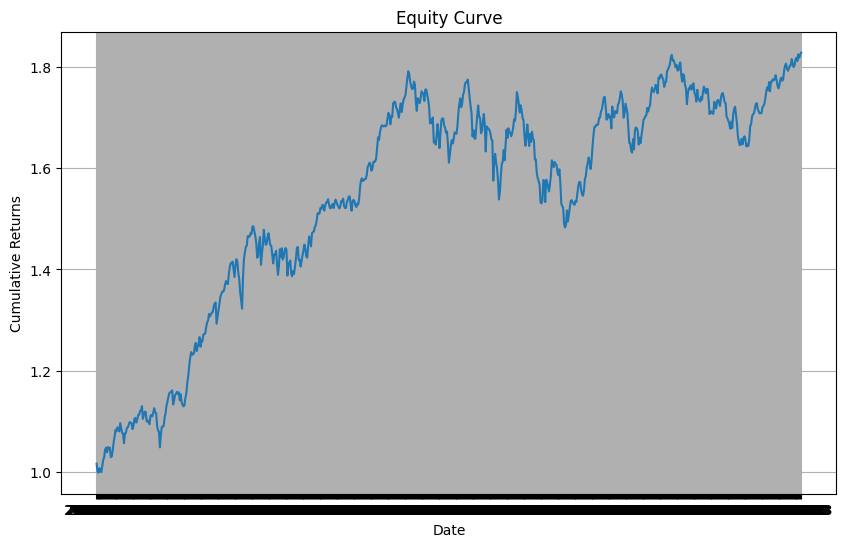

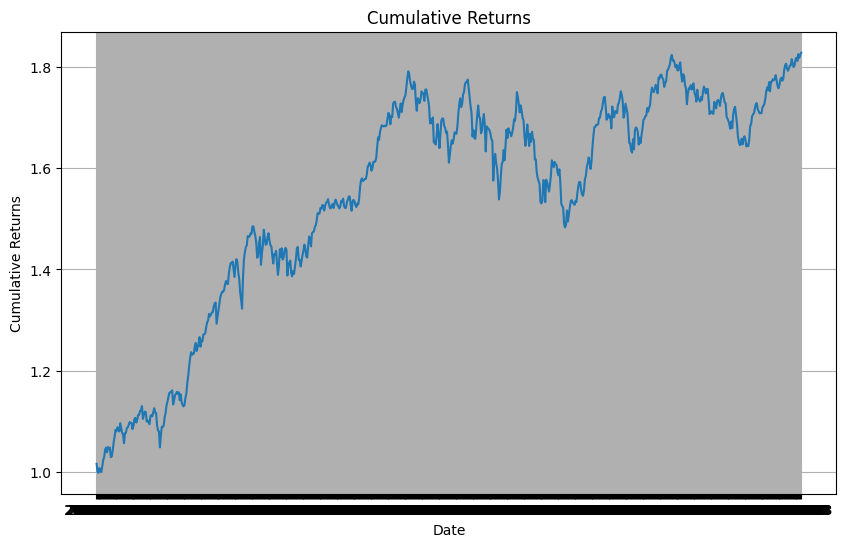

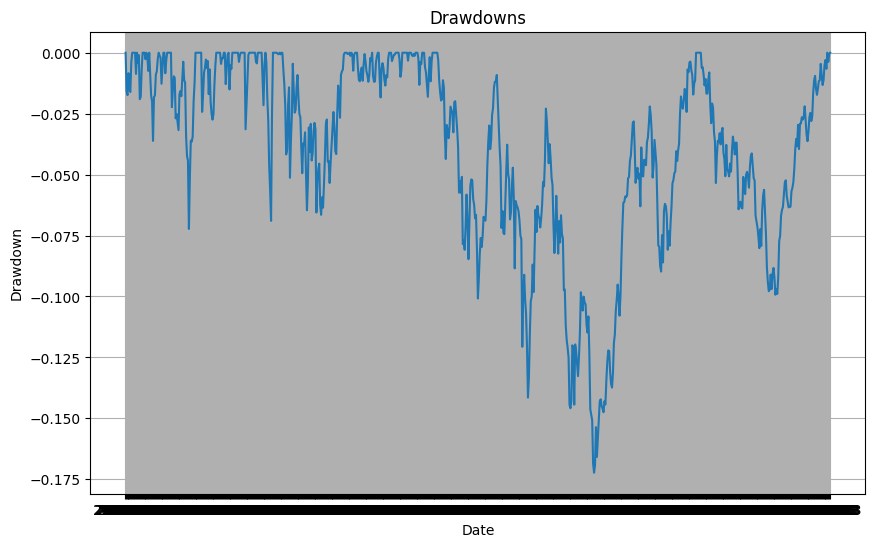

In [4]:
import numpy as np
import matplotlib.pyplot as plt

backtest_results = pd.read_csv('Backtesting.csv')
backtest_results['Returns'] = backtest_results['Close'].pct_change()
volatility = np.std(backtest_results['Returns']) * np.sqrt(252)

backtest_results['CumulativeReturns'] = (1 + backtest_results['Returns']).cumprod()
backtest_results['Peak'] = backtest_results['CumulativeReturns'].cummax()
backtest_results['Drawdown'] = (backtest_results['CumulativeReturns'] / backtest_results['Peak']) - 1
backtest_results['Returns'] = backtest_results['Close'].pct_change()
max_drawdown = min(backtest_results['Drawdown'])

risk_free_rate = 0.05
sharpe_ratio = (np.mean(backtest_results['Returns']) - risk_free_rate) / volatility

print("Volatility:", volatility)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)
print(backtest_results[['Date', 'Returns', 'CumulativeReturns']])

cumulative_returns_file = 'CumulativeReturns.csv'
backtest_results[['Date', 'CumulativeReturns']].to_csv(cumulative_returns_file, index=False)

plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['CumulativeReturns'])
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['CumulativeReturns'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['Drawdown'])
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

In [5]:
pip install git+https://github.com/quantopian/pyfolio

  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-5rn8d1n_
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-5rn8d1n_
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.9 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75761 sha256=332a06d7f1e4f8627487941de85150c54154331f4d49bbe5b23346869c2c6c33
  Stored in directory: /tmp/pip-ephem-wheel-cache-th7x5qcx/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39762 sha256=f98d9f70d2faf454c5501cb3648d542e9918ed4c6832dc723664f5e665a8dec2
  Stored in d

/usr/local/lib/python3.10/dist-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; multipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-06-23
End date,2023-06-21
Total months,35
,Backtest
Annual return,22.586%
Cumulative returns,82.877%
Annual volatility,15.524%
Sharpe ratio,1.39
Calmar ratio,1.31
Stability,0.71
Max drawdown,-17.23%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.23,2021-10-18,2022-06-17,2022-11-24,289
1,9.93,2022-12-01,2023-03-24,2023-06-16,142
2,7.23,2020-08-28,2020-09-24,2020-10-06,28
3,6.90,2021-01-20,2021-01-29,2021-02-02,10
4,6.65,2021-02-15,2021-04-20,2021-05-27,74


Benchmark Returns DataFrame Index:
DatetimeIndex(['2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29', '2020-06-30', '2020-07-01',
               '2020-07-02', '2020-07-03',
               ...
               '2023-06-08', '2023-06-09', '2023-06-12', '2023-06-13',
               '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-19',
               '2023-06-20', '2023-06-21'],
              dtype='datetime64[ns]', name='Date', length=748, freq=None)


Start date,2020-06-24
End date,2023-06-21
Total months,35
,Backtest
Annual return,21.984%
Cumulative returns,80.086%
Annual volatility,15.511%
Sharpe ratio,1.36
Calmar ratio,1.28
Stability,0.71
Max drawdown,-17.23%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.23,2021-10-18,2022-06-17,2022-11-24,289
1,9.93,2022-12-01,2023-03-24,2023-06-16,142
2,7.23,2020-08-28,2020-09-24,2020-10-06,28
3,6.90,2021-01-20,2021-01-29,2021-02-02,10
4,6.65,2021-02-15,2021-04-20,2021-05-27,74


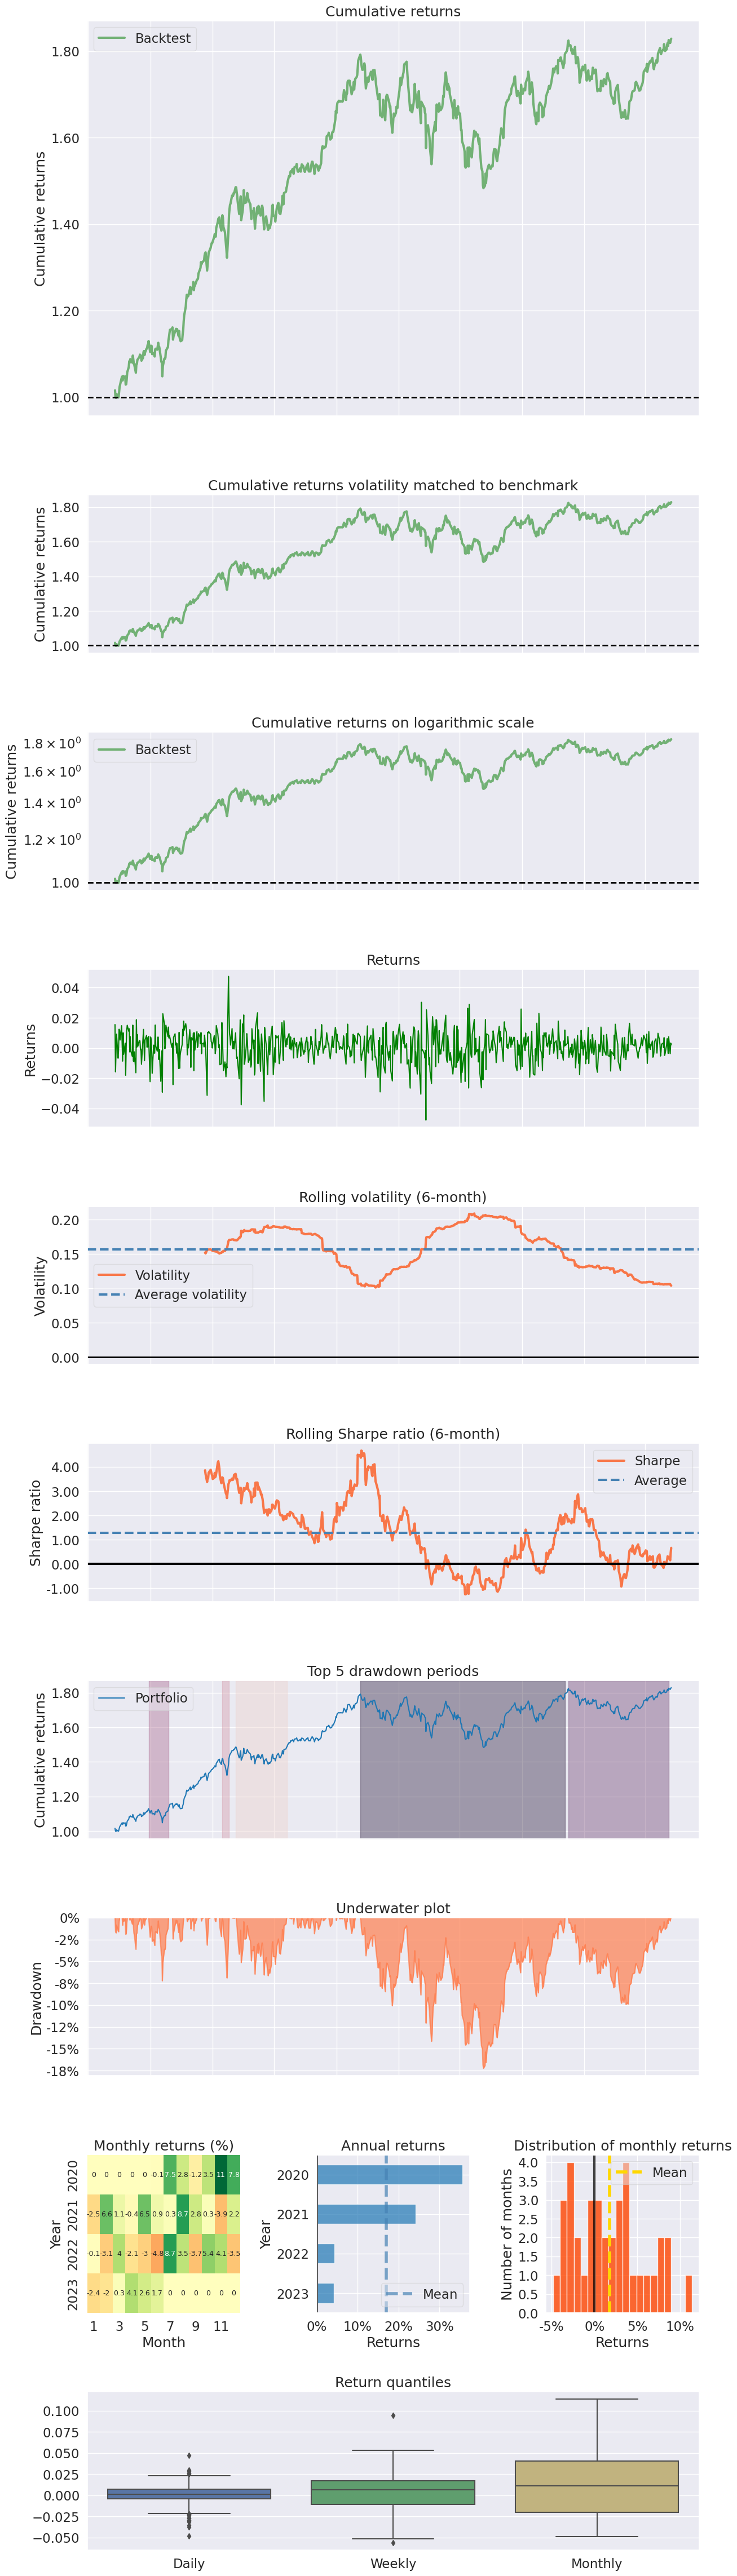

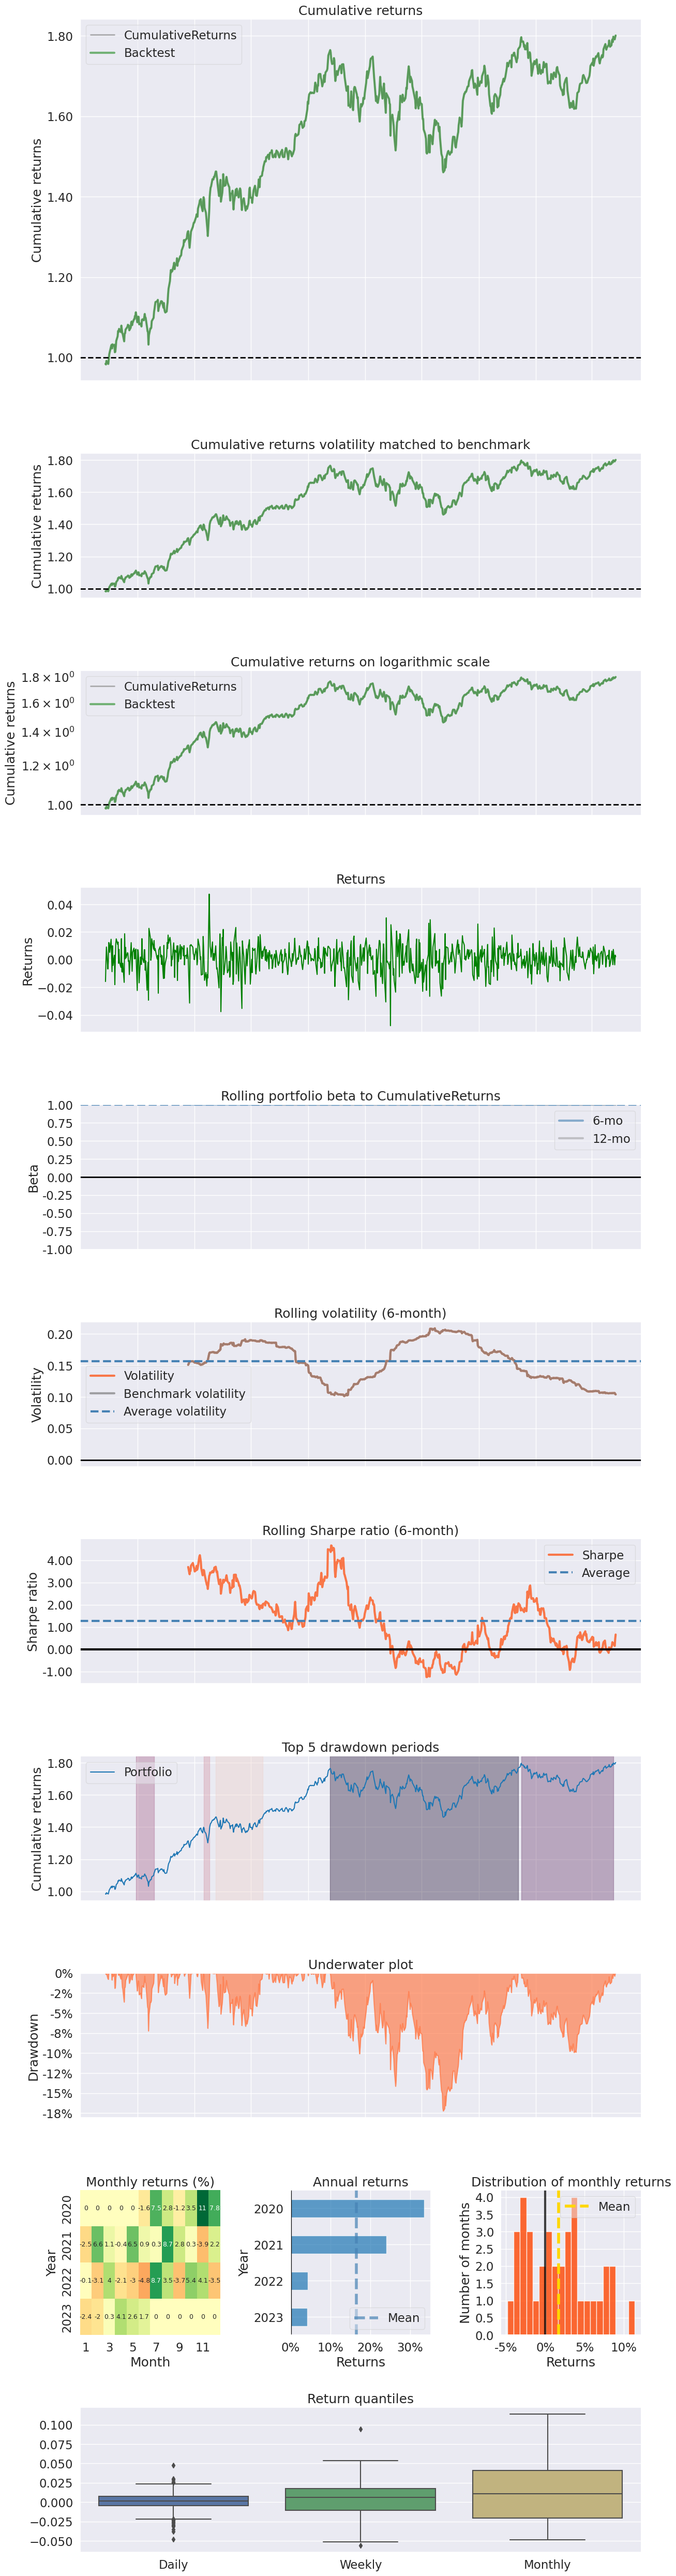

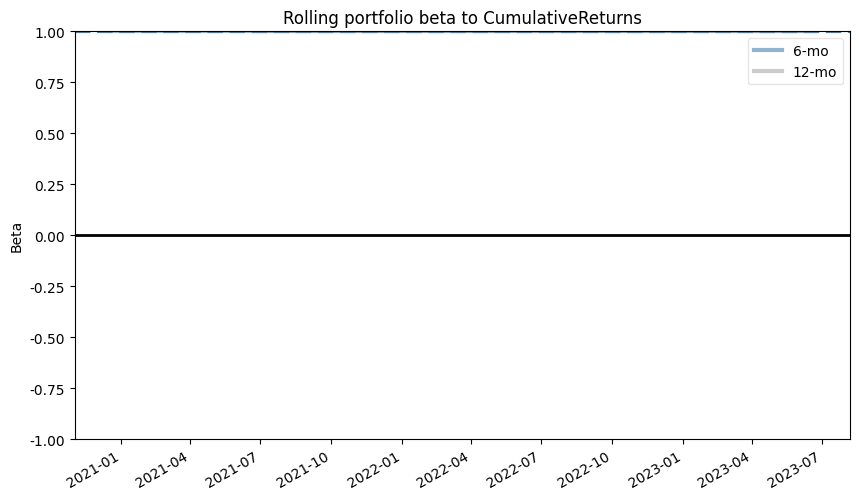

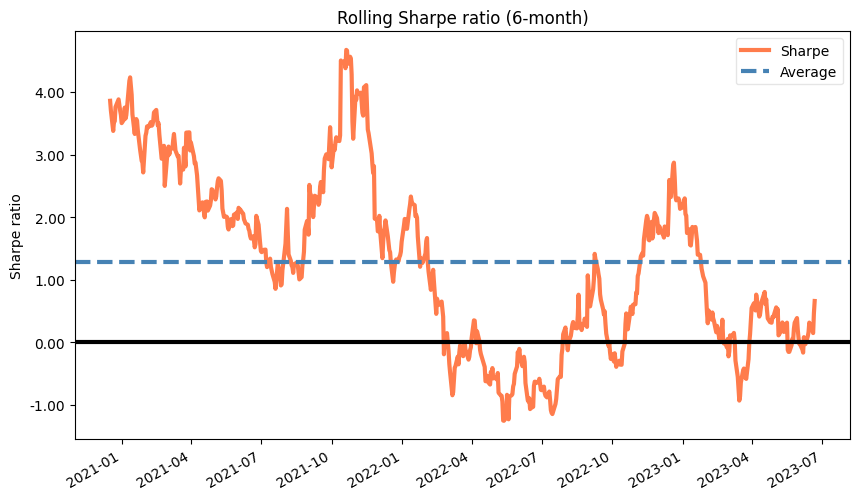

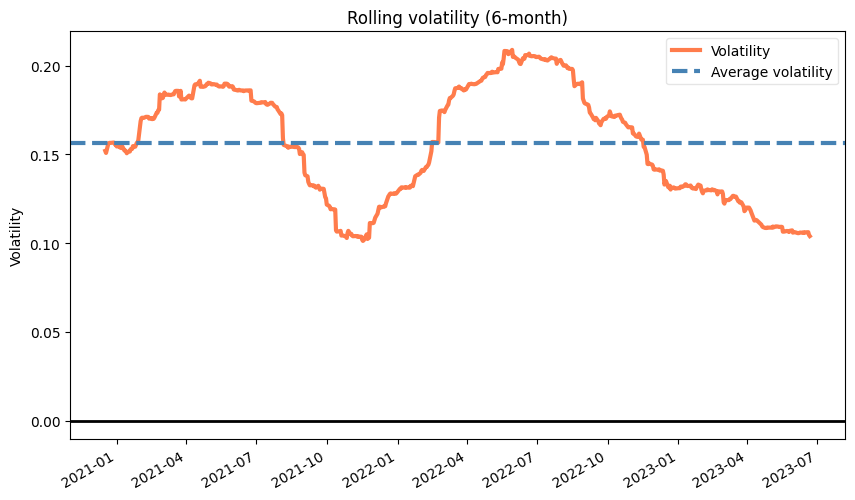

In [6]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

backtest_results = pd.read_csv('Backtesting.csv')
backtest_results['Date'] = pd.to_datetime(backtest_results['Date'], format='%d-%m-%y')
backtest_results.set_index('Date', inplace=True)
backtest_results['Returns'] = backtest_results['Close'].pct_change()
returns = backtest_results['Returns'].dropna()

if not isinstance(returns.index, pd.DatetimeIndex):
    returns.index = pd.to_datetime(returns.index)

pf.create_returns_tear_sheet(returns, benchmark_rets=None)

benchmark_returns = pd.read_csv('CumulativeReturns.csv', index_col=0)
benchmark_returns.index = pd.to_datetime(benchmark_returns.index, format='%d-%m-%y')
print("Benchmark Returns DataFrame Index:")
print(benchmark_returns.index)

benchmark_returns = benchmark_returns.pct_change().dropna()['CumulativeReturns']
pf.create_returns_tear_sheet(returns, benchmark_rets=benchmark_returns)

plt.figure(figsize=(10, 6))
pf.plotting.plot_rolling_beta(returns, benchmark_returns)
plt.show()

plt.figure(figsize=(10, 6))
pf.plotting.plot_rolling_sharpe(returns)
plt.show()

plt.figure(figsize=(10, 6))
pf.plotting.plot_rolling_volatility(returns)
plt.show()

warnings.filterwarnings("default")